<a href="https://colab.research.google.com/github/zq1412/StreamlitLSTMStockPrediction/blob/main/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Relevant Libraries 

In [138]:
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import RNNModel
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import forecasting
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller


import yfinance as yf

## Data Pre-Processing 

In [139]:
#Getting date from one year ago
one_year_ago = datetime.now() - relativedelta(years=1) 
one_year_ago = one_year_ago.strftime("%Y-%m-%d")

#Getting date today
today = datetime.now()
today = today.strftime("%Y-%m-%d")

#Adding one day to the date one year ago 
one_year_ago_plus_one = datetime.now() - relativedelta(years=1) + timedelta(days=1)
one_year_ago_plus_one = one_year_ago_plus_one.strftime("%Y-%m-%d")

#Accessing YFinance
ticker= yf.Ticker("fico")

#Getting pandas dataframe of stock data from one year ago
df = ticker.history(start=one_year_ago, end=today, interval="1d")
idx = pd.date_range(start=one_year_ago_plus_one, end=today)




#Making index into Datetime index
df.index = pd.DatetimeIndex(df.index)
df.index = df.index.tz_localize(None) 

#Reindexing dataframe to fill in missing dates due to stock market closing on weekends
df = df.reindex(idx, method = 'pad')


print(df)



                  Open        High         Low       Close  Volume  Dividends  \
2022-05-09  345.649994  350.619995  340.480011  341.440002  303100        0.0   
2022-05-10  347.730011  362.040009  345.440002  358.410004  357800        0.0   
2022-05-11  353.450012  364.309998  349.170013  351.089996  250300        0.0   
2022-05-12  347.239990  357.769989  346.660004  352.730011  244900        0.0   
2022-05-13  356.640015  365.700012  352.809998  361.529999  189900        0.0   
...                ...         ...         ...         ...     ...        ...   
2023-05-04  748.669983  760.150024  736.000000  736.650024  208100        0.0   
2023-05-05  739.919983  743.369995  730.330017  731.979980  148300        0.0   
2023-05-06  739.919983  743.369995  730.330017  731.979980  148300        0.0   
2023-05-07  739.919983  743.369995  730.330017  731.979980  148300        0.0   
2023-05-08  739.919983  743.369995  730.330017  731.979980  148300        0.0   

            Stock Splits  


In [140]:
#Put dataframe into a Darts "Timeseries" object so that data can be fed into a Darts forecasting model. For more information on Timeseries objects, please look here: https://unit8co.github.io/darts/generated_api/darts.timeseries.html 
series = TimeSeries.from_dataframe(df)

#Drop all columns besides "Close" Column
adj_series = series.drop_columns(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

Text(0.5, 1.0, 'Training and Validation Plots')

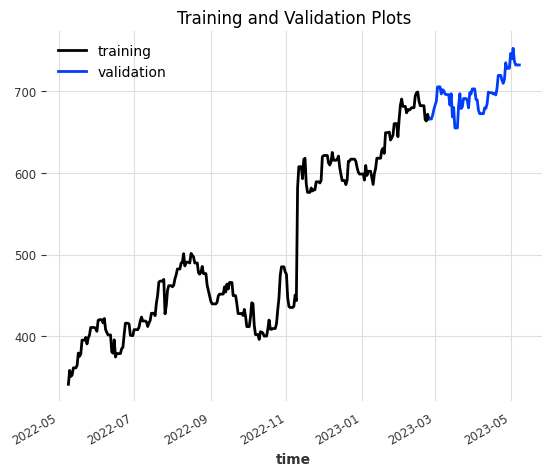

In [141]:

#Divide dataset into training and validation/testing sets. "Split_after" function is a method of a Darts Timeseries object. https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.split_after
training, validation = adj_series.split_after(0.8)

#Plot training and testing data
training.plot(label='training')
validation.plot(label='validation')
plt.legend();
plt.title("Training and Validation Plots")

In [142]:
#Transform training set, validation set, and entire series to values between 0 and 1.
transformer = Scaler()
train_transformed = transformer.fit_transform(training)
val_transformed = transformer.transform(validation)
series_transformed = transformer.transform(adj_series)
print(train_transformed)
print(val_transformed)
print(series_transformed)

<TimeSeries (DataArray) (time: 292, component: 1, sample: 1)>
array([[[0.        ]],

       [[0.04746853]],

       [[0.02699299]],

       [[0.03158044]],

       [[0.05619579]],

       [[0.05619579]],

       [[0.05619579]],

       [[0.06422375]],

       [[0.10674127]],

       [[0.09563637]],

...

       [[1.        ]],

       [[0.96883912]],

       [[0.95314685]],

       [[0.95314685]],

       [[0.95314685]],

       [[0.95314685]],

       [[0.90506293]],

       [[0.90081113]],

       [[0.92372023]],

       [[0.90769231]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-05-09 2022-05-10 ... 2023-02-24
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
<TimeSeries (DataArray) (time: 73, component: 1, sample: 1)>
array([[[0.90769231]],

       [[0.90769231]],

       [[0.92019572]],

       [[0.93972031]],

       [[0.95482511]],

       [[0.96805599]],

       [[1

## Construct LSTM Model in Darts

In [143]:
#Define LSTM Model
my_model = RNNModel(
    model="LSTM",
    n_rnn_layers = 3, # Number of LSTM layers
    hidden_dim=4,
    dropout=0.2,
    batch_size=16,
    n_epochs=10,
    optimizer_kwargs={"lr": 1e-3}, #learning rate
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
)

#Fit model on training data
my_model.fit(train_transformed)

#Predict values 
pred = my_model.predict(n=len(val_transformed))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 432   
4 | V             | Linear           | 5     
---------------------------------------------------
437       Trainable params
0         Non-trainable params
437       Total params
0.002     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of trainin

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

## Evaluating Results

MAPE = 50.62%


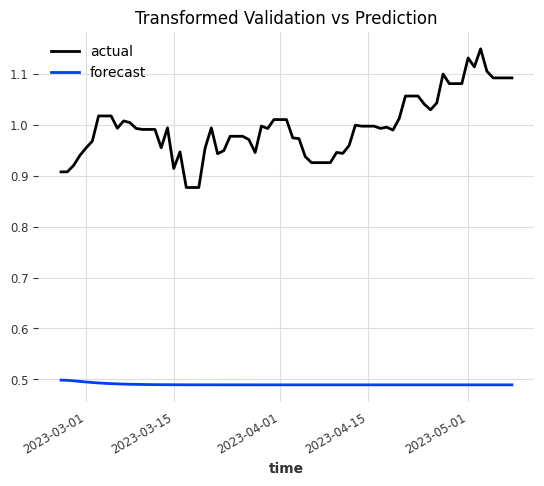

In [144]:
#Plot transformed validation set vs prediction 
val_transformed.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
plt.title("Transformed Validation vs Prediction")
print('MAPE = {:.2f}%'.format(mape(val_transformed, pred)))


MAPE = 25.86%


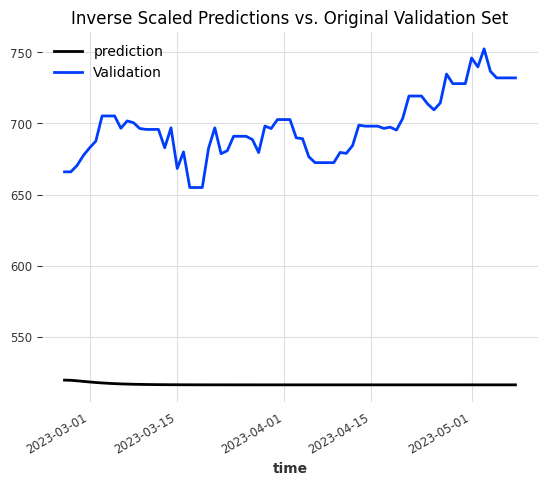

In [145]:
#Perform inverse scaling on prediction
inverse_scaler_pred = transformer.inverse_transform(pred)

#Plot inverse scaled predictions with validation  
inverse_scaler_pred.plot(label='prediction')
validation.plot(label='Validation')
plt.legend();
plt.title("Inverse Scaled Predictions vs. Original Validation Set")
print('MAPE = {:.2f}%'.format(mape(validation, inverse_scaler_pred)))

MAPE = 25.86%


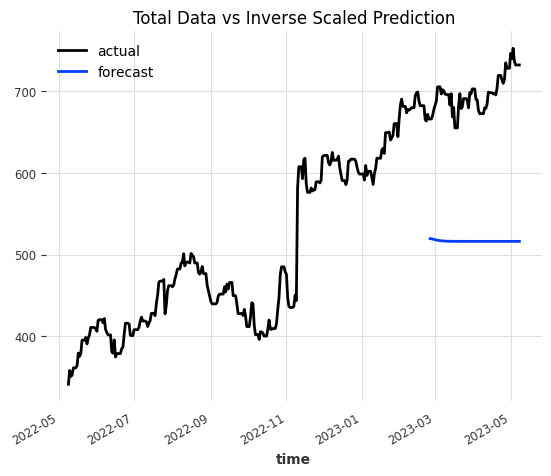

In [146]:
#Plot total data vs prediction
adj_series.plot(label='actual')
inverse_scaler_pred.plot(label='forecast')
plt.legend();
plt.title("Total Data vs Inverse Scaled Prediction")
print('MAPE = {:.2f}%'.format(mape(adj_series, inverse_scaler_pred)))

In [147]:
# import optuna
# from sklearn.model_selection import cross_val_score


# def objective(trial):

#     n_rnn_layers = trial.suggest_int("n_rnn_layers", 1, 5)
#     hidden_dim = trial.suggest_int("hidden_dim", 1, 5)
#     input_chunk_length = trial.suggest_int("input_chunk_length", 1,5)

#     my_model = RNNModel(
#     model="LSTM",
#     n_rnn_layers = n_rnn_layers,
#     hidden_dim= hidden_dim,
#     input_chunk_length=input_chunk_length
#     )

#     my_model.fit(training)

#     preds = my_model.predict(series=training, n=len(validation))
#     mapes = mape(validation, preds, n_jobs=-1, verbose=True)
#     smape_val = np.mean(mapes)

#     return smape_val if smape_val != np.nan else float("inf")


# def print_callback(study, trial):
#     print(f"Current value: {trial.value}, Current params: {trial.params}")
#     print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=5, callbacks=[print_callback])




In [148]:
# !pip install yfinance
# !pip install darts

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import pandas as pd
# #import shutil
# from sklearn.preprocessing import MinMaxScaler
# #from tqdm import tqdm_notebook as tqdm
# import matplotlib.pyplot as plt

# from darts import TimeSeries
# from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
# from darts.metrics import mape, mse
# #from darts.utils.statistics import check_seasonality, plot_acf
# #from darts.datasets import AirPassengersDataset, SunspotsDataset
# from darts.utils.timeseries_generation import datetime_attribute_timeseries
# from darts.models import forecasting
# from darts.dataprocessing.transformers import Scaler, MissingValuesFiller

# import yfinance as yf
# tickers = ['AAPL', 'ACN', 'ADBE', 'ADI', 'ADSK', 'AKAM', 'AMAT', 'AMD', 'ANET', 'ANSS']
# for tk in tickers:
#     ticker= yf.Ticker(tk)
#     df = ticker.history(start="2022-04-01", end="2023-04-01", interval="1d")

#     # data.reset_index(inplace=True)
#     # data = data[['Date', 'Close']]

#     idx = pd.date_range(start='2022-04-01', end='2023-04-01')
#     df.index = pd.DatetimeIndex(df.index)
#     df.index = df.index.tz_localize(None) 
#     # # #df['Date'] = pd.to_datetime(df['Date'])
#     # # #print(df)
#     # # #df.set_index='Date'
#     # # #print(df)
#     # # df.index = pd.DatetimeIndex(df.index)
#     # # print(df)
#     df = df.reindex(idx, method = 'pad')
#     print(df)
#     series = TimeSeries.from_dataframe(df)
#     print(series)

#     adj_series = series.drop_columns(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])
#     training, validation = adj_series.split_after(0.8)
#     training.plot(label='training')
#     validation.plot(label='validation')
#     plt.legend();
#     from darts.dataprocessing.transformers import Scaler
#     transformer = Scaler()
#     train_transformed = transformer.fit_transform(training)
#     val_transformed = transformer.transform(validation)
#     series_transformed = transformer.transform(adj_series)
#     print(train_transformed)
#     print(val_transformed)
#     print(series_transformed)
#     # scaler_stock = Scaler()
#     # series_stock_scaled = scaler_stock.fit_transform(adj_series)
#     # print(series_stock_scaled)
#     # training, validation = adj_series.split_after(0.8)
#     my_model = RNNModel(
#         model="LSTM",
#         n_rnn_layers = 3,
#         hidden_dim=4,
#         dropout=0,
#         batch_size=16,
#         n_epochs=10,
#         optimizer_kwargs={"lr": 1e-3},
#         model_name="Air_RNN",
#         log_tensorboard=True,
#         random_state=42,
#         training_length=20,
#         input_chunk_length=3,
#         force_reset=True,
#         save_checkpoints=True,
#     )
#     my_model.fit(train_transformed)
#     pred = my_model.predict(n=len(val_transformed))
#     val_transformed.plot(label='actual')
#     pred.plot(label='forecast')
#     plt.legend();
#     print('MAPE = {:.2f}%'.format(mape(val_transformed, pred)))
#     series_transformed.plot(label='actual')
#     pred.plot(label='forecast')
#     plt.legend();
#     print('MAPE = {:.2f}%'.format(mape(series_transformed, pred)))
#     inverse_scaler_pred = transformer.inverse_transform(pred)

#     inverse_scaler_pred.plot(label='prediction')
#     validation.plot(label='Validation')
#     plt.legend();

#     !pip install optuna
#     import optuna
#     from sklearn.model_selection import cross_val_score


#     def objective(trial):

#         n_rnn_layers = trial.suggest_int("n_rnn_layers", 1, 5)
#         hidden_dim = trial.suggest_int("hidden_dim", 1, 5)
#         input_chunk_length = trial.suggest_int("input_chunk_length", 1,5)

#         my_model = RNNModel(
#         model="LSTM",
#         n_rnn_layers = n_rnn_layers,
#         hidden_dim= hidden_dim,
#         input_chunk_length=input_chunk_length
#         )

#         my_model.fit(training)

#         preds = my_model.predict(series=training, n=len(validation))
#         mapes = mape(validation, preds, n_jobs=-1, verbose=True)
#         smape_val = np.mean(mapes)

#         return smape_val if smape_val != np.nan else float("inf")


#     def print_callback(study, trial):
#         print(f"Current value: {trial.value}, Current params: {trial.params}")
#         print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

#     study = optuna.create_study(direction="minimize")
#     study.optimize(objective, n_trials=5, callbacks=[print_callback])


